In [85]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.filters import gaussian
from skimage.measure import label, regionprops

In [86]:
BASE = "/Users/umutcancubukcu/PycharmProjects/cs419-finito"
IMG_DIR = os.path.join(BASE, "DIC-C2DH-HeLa", "01")
GT_TRA  = os.path.join(BASE, "DIC-C2DH-HeLa", "01_GT", "TRA")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

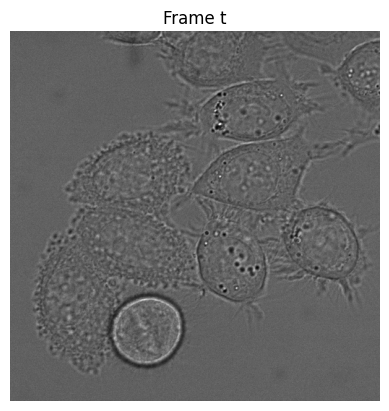

In [87]:
def load_frame(t):
    path = os.path.join(IMG_DIR, f"t{t:03d}.tif")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise FileNotFoundError(path)

    return img

img_t = load_frame(10)
plt.imshow(img_t, cmap="gray")
plt.title("Frame t")
plt.axis("off")

In [88]:
def preprocess(img):
    img = img.astype(np.float32)
    img = gaussian(img, sigma=1.0)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img


I_t  = preprocess(load_frame(10))
I_t1 = preprocess(load_frame(11))

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

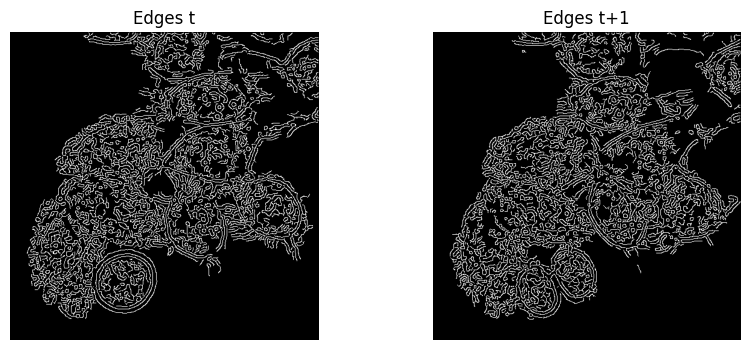

In [89]:
E_t  = canny(I_t,  sigma=1.0)
E_t1 = canny(I_t1, sigma=1.0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(E_t, cmap="gray")
plt.title("Edges t")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(E_t1, cmap="gray")
plt.title("Edges t+1")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

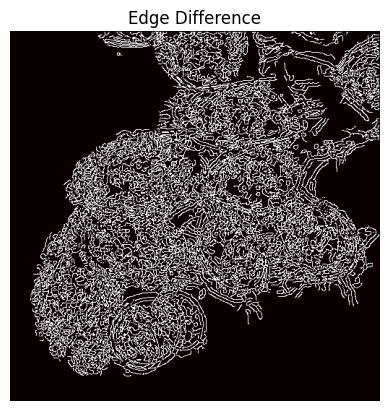

In [90]:
D = np.abs(E_t1.astype(np.int32) - E_t.astype(np.int32))

plt.imshow(D, cmap="hot")
plt.title("Edge Difference")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

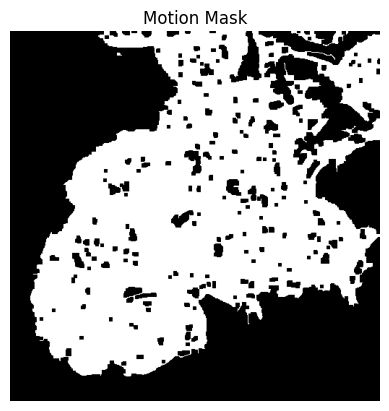

In [91]:
motion_mask = D > 0

kernel = np.ones((3,3), np.uint8)
motion_mask = cv2.morphologyEx(
    motion_mask.astype(np.uint8),
    cv2.MORPH_CLOSE,
    kernel,
    iterations=2
)

plt.imshow(motion_mask, cmap="gray")
plt.title("Motion Mask")
plt.axis("off")

In [92]:
labels = label(motion_mask)
regions = regionprops(labels)

print("Candidate regions:", len(regions))

Candidate regions: 5


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

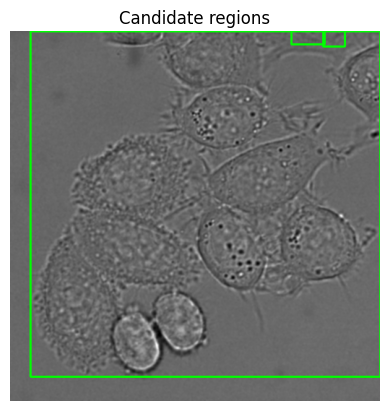

In [93]:
vis = cv2.cvtColor((I_t1*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

for r in regions:
    if r.area < 40:
        continue
    y0, x0, y1, x1 = r.bbox
    cv2.rectangle(vis, (x0,y0), (x1,y1), (0,255,0), 2)

plt.imshow(vis)
plt.title("Candidate regions")
plt.axis("off")

In [94]:
def compute_cht(region_img):
    edges = canny(region_img, sigma=1.0)
    radii = np.arange(5, 18)

    h = hough_circle(edges, radii)
    accums, cx, cy, r = hough_circle_peaks(h, radii, total_num_peaks=1)

    if len(accums) == 0:
        return 0.0
    return accums[0]

In [95]:
candidates = []

for r in regions:
    if r.area < 40:
        continue

    y0,x0,y1,x1 = r.bbox
    patch = I_t1[y0:y1, x0:x1]

    candidates.append({
        "bbox": r.bbox,
        "area": r.area,
        "cht": compute_cht(patch)
    })

candidates[:5]

[{'bbox': (0, 28, 478, 512),
  'area': np.float64(129479.0),
  'cht': np.float64(0.7500000000000003)},
 {'bbox': (0, 389, 18, 435),
  'area': np.float64(298.0),
  'cht': np.float64(0.3125)},
 {'bbox': (0, 433, 21, 463),
  'area': np.float64(184.0),
  'cht': np.float64(0.33333333333333326)}]

In [96]:
def temporal_cht(t, bbox):
    scores = []
    for dt in [-1, 0, 1]:
        img = preprocess(load_frame(t+dt))
        y0,x0,y1,x1 = bbox
        patch = img[y0:y1, x0:x1]
        scores.append(compute_cht(patch))
    return scores


for c in candidates:
    c["signature"] = temporal_cht(11, c["bbox"])

In [97]:
def is_mitosis(c):
    s = c["signature"]
    return s[1] > s[0] and s[1] > s[2] and s[1] > 0.35
mitosis = [c for c in candidates if is_mitosis(c)]
print("Detected mitosis:", len(mitosis))

Detected mitosis: 1


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

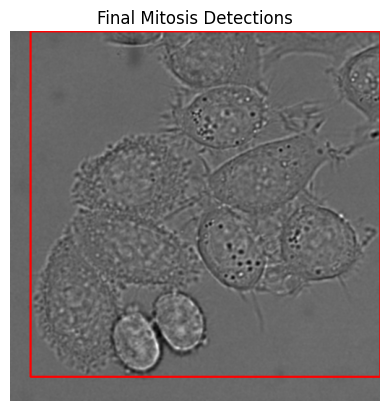

In [98]:
final = cv2.cvtColor((I_t1*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

for c in mitosis:
    y0,x0,y1,x1 = c["bbox"]
    cv2.rectangle(final, (x0,y0), (x1,y1), (255,0,0), 2)
    cv2.putText(final, "MITOSIS", (x0,y0-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

plt.imshow(final)
plt.title("Final Mitosis Detections")
plt.axis("off")

In [99]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [100]:
# Dataset paths (adjust if needed)
ROOT = "DIC-C2DH-HeLa"
SEQ = "01"

IMG_DIR = os.path.join(ROOT, SEQ)
TRA_DIR = os.path.join(ROOT, f"{SEQ}_GT/TRA")
TRA_TXT = os.path.join(TRA_DIR, "man_track.txt")

In [101]:
# Parse man_track.txt to find mitosis parents
children_by_parent = defaultdict(list)

with open(TRA_TXT, "r") as f:
    for line in f:
        tid, parent, start, end = map(int, line.strip().split())
        if parent != 0:
            children_by_parent[parent].append((tid, start))

# GT mitosis events = parents with >= 2 children
gt_mitosis_events = []
for parent, children in children_by_parent.items():
    if len(children) >= 2:
        mitosis_frame = min(c[1] for c in children) - 1
        gt_mitosis_events.append({
            "parent_id": parent,
            "frame": mitosis_frame
        })

print("Number of GT mitosis events:", len(gt_mitosis_events))

Number of GT mitosis events: 9


In [102]:
def edge_diff_energy(frame_t, frame_t1, region_mask):
    """
    Compute edge difference energy inside a GT parent region.
    """
    edges_t  = cv2.Canny(frame_t,  50, 150)
    edges_t1 = cv2.Canny(frame_t1, 50, 150)

    diff = np.abs(edges_t1.astype(np.int16) - edges_t.astype(np.int16))
    return float(np.sum(diff * region_mask))

In [103]:
def load_parent_mask(parent_id, frame_idx):
    """
    Load binary mask of a specific parent cell at a given frame.
    """
    mask_path = os.path.join(TRA_DIR, f"man_track{frame_idx:03d}.tif")
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        return None
    return (mask == parent_id).astype(np.uint8)

In [104]:
def safe_read_image(t):
    if t < 0 or t > MAX_FRAME:
        return None
    path = os.path.join(IMG_DIR, f"t{t:03d}.tif")
    if not os.path.exists(path):
        return None
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [105]:
def measure_event_response(event, window=3):
    pid = event["parent_id"]
    t0  = event["frame"]

    responses = []

    for dt in range(-window, window + 1):
        t = t0 + dt
        if t < 0:
            continue

        img_t  = safe_read_image(t)
        img_t1 = safe_read_image(t+1)

        if img_t is None or img_t1 is None:
            continue
        mask   = load_parent_mask(pid, t)

        if img_t is None or img_t1 is None or mask is None:
            continue

        energy = edge_diff_energy(img_t, img_t1, mask)
        responses.append((t, energy))

    return responses

In [106]:
event = gt_mitosis_events[0]  # pick first GT event
responses = measure_event_response(event)

frames, energies = zip(*responses)

plt.figure(figsize=(6,4))
plt.plot(frames, energies, marker="o")
plt.axvline(event["frame"], color="red", linestyle="--", label="GT mitosis")
plt.xlabel("Frame")
plt.ylabel("Edge-diff energy")
plt.title(f"GT Mitosis Temporal Response (Parent {event['parent_id']})")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'MAX_FRAME' is not defined

In [81]:
test_path = os.path.join(IMG_DIR, "t080.tif")
print(test_path)
print("Exists?", os.path.exists(test_path))

DIC-C2DH-HeLa/01/t080.tif
Exists? True
